In [1]:
from modules.v2x import V2XData
import sklearn.metrics as skm
from tsai.all import *
from modules.RunTSAI import RunTSAI
# import wandb
# my_setup(wandb)
# wandb.login()

config_default = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = LSTM,
    lr = 1e-3,
    n_epochs = 20,
)
    
def multivariate_classification(X, y, splits, config=config_default, metrics=accuracy, lr_find=False, load_ckpt = False
                                , save: str = 'multivariate_classification'):
    "model_input: LSTM, LSTMPlus, MLSTM_Plus, LSTM_FCN"
    
    tfms = [None, [TSCategorize()]]
    check_data(X, y, splits=splits)
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=256, batch_tfms=config["batch_tfms"])
    
    m = create_model(config["architecture"], dls = dls)
    learn = Learner(dls, m, metrics=metrics)
    if lr_find:
        learn.lr_find()
    learn.fit(config["n_epochs"], config["lr"], cbs=SaveModel(monitor='accuracy', fname=save))
    learn.recorder.plot_metrics()
    learn.save('classification')
    return learn

def multivariate_classification_wandb(X, y, splits, metrics=accuracy, config = config_default, proj_name = "50-1 V2X TSClassification", lr_find=False, load_ckpt = False
                                , save: str = 'multivariate_classification'):
    # "model_input: LSTM, LSTMPlus, MLSTM_Plus, LSTM_FCN"
    
    with wandb.init(project="multivariate_classification", config=config, name = proj_name) as run:
        # wandb records every epoch
        tfms = [None, [TSCategorize()]]
        check_data(X, y, splits=splits)
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
        cbs = [ShowGraph(), WandbCallback(log_preds=False, log_model=False)]
        dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=256, batch_tfms=config["batch_tfms"])
        
        m = create_model(config["architecture"], dls = dls)
        learn = Learner(dls, m, metrics=metrics)
        if lr_find:
            learn.lr_find()
        learn.fit(config["n_epochs"], config["lr"], cbs=cbs)
        learn.recorder.plot_metrics()
        learn.save('classification')
        return learn
    
def minirocket_classification(X, y, splits, epochs=20, model=MiniRocketPlus, lr = 1e-3, metrics=accuracy, lr_find=False, save: str = 'minirocket_classification'):
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    batch_tfms = TSStandardize(by_sample=True)
    dls = get_ts_dls(X, y, bs=256, tfms=tfms, batch_tfms=batch_tfms, splits=splits)
    
    m = create_model(model, dls = dls)
    learn = ts_learner(dls, m, kernel_size=len(X[0]), metrics=metrics)
    if lr_find:
        learn.lr_find()
    learn.fit(epochs, lr)
    learn.recorder.plot_metrics()
    if save:
        learn.save(save)
    return learn

def multivariate_forecasting(X, y, splits, epochs=20, model=LSTM, lr = 1e-3, metrics=mae, lr_find=False):
    "model_input: LSTM, LSTMPlus, MLSTM_Plus, LSTM_FCN"
    splits = TSSplitter()(y)
    tfms = [None, [TSRegression()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    batch_tfms = TSStandardize(by_var=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    
    m = create_model(model, dls = dls)
    learn = TSForecaster(X, y, splits=splits, batch_tfms=batch_tfms, arch=None, arch_config=dict(fc_dropout=.2), metrics=metrics, bs=512,
                         partial_n=.1, train_metrics=True)
    if lr_find:
        learn.lr_find()
    learn.fit(epochs, lr)
    learn.recorder.plot_metrics()
    learn.save('forecasting')
    return learn

loaded 46 files
['./data/Sejong/0901_5RNBVU80.csv', './data/Sejong/0901_OKG5RJW0.csv', './data/Sejong/0902_5RNBVU80.csv', './data/Sejong/0902_9CU6AVIU.csv', './data/Sejong/0903_5RNBVU80.csv'] ...
df[2] shape: (10459, 11)
files index: 0 ~ 46


100%|██████████| 46/46 [00:14<00:00,  3.17it/s]

X_sum shape: (35300, 9, 10), y_sum shape: (35300,)
X      - shape: [35300 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (35300,)  type: ndarray  dtype:int64  isnan: 0
splits - n_splits: 2 shape: [17650, 17650]  overlap: False


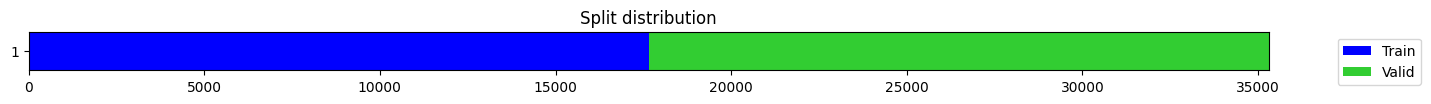

,HEADING,SPEED,HAZARDLIGHTS_FLAG,HARDBRAKING_FLAG,LIGHTSCHANGE_FLAG,HARDDECELERATION_FLAG,UTURN_FLAG,LIGHTS_STATUS,CURRENT_LANE,scene,Hazard
0,-1.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scene_3,False
1,-1.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scene_3,False
2,-1.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scene_3,False


In [2]:
files_path = './data/Sejong'
v2xdata = V2XData(files_path, hazard_thr=3)
X, y, splits, df = v2xdata[2]
# check_data(X, y, splits=splits)
X_all, y_all, splits, df_all = v2xdata.get_all_item()
check_data(X_all, y_all, splits=splits)
df.head(3)

In [3]:
for col in df_all.columns:
    ignore_col = ['HEADING', 'SPEED', 'X', 'Y', 'scene', 'Hazard']
    if col in ignore_col:
        continue
    print(f'{col}: {df_all[col].unique()}')

HAZARDLIGHTS_FLAG: [ 0.  1. -1.  2. -2.]
HARDBRAKING_FLAG: [ 0.  1. -1.  2. -2.]
LIGHTSCHANGE_FLAG: [ 0.  1. -1.  2. -2.]
HARDDECELERATION_FLAG: [ 0.  1. -1.]
UTURN_FLAG: [ 0.  1. -1.]
LIGHTS_STATUS: [  0.   4.   8.  -4.  -8.  16. -16. -12.  12.  28. -28. -20.  24. -24.
  20.]
CURRENT_LANE: [ 0.  4. -4.  3.  2. -3. -2. -1.  1. -5.  6. -6.  5. -7.  7.  8.]


In [ ]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = skm.confusion_matrix(y_test, pred) # 오차행렬
    accuracy = skm.accuracy_score(y_test, pred) # 정확도
    precision = skm.precision_score(y_test, pred) # 정밀도
    recall = skm.recall_score(y_test, pred) # 재현율
    f1 = skm.f1_score(y_test, pred) # f1 score
    print(f'오차행렬 : \n{confusion}\n\nTN = {confusion[0, 0]}, FP = {confusion[0, 1]}\nFN = {confusion[1, 0]}, TP = {confusion[1, 1]}\n')
    print(f'정확도 : {round(accuracy, 4)} \n정밀도 : {round(precision, 4)} \n재현율 : {round(recall, 4)} \nF1 score : {round(f1, 4)}')

# train

In [ ]:
config = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = LSTM,
    lr = 1e-3,
    n_epochs = 300,
)

learner = multivariate_classification(X_all, y_all, splits, metrics=accuracy, config = config, lr_find=False, load_ckpt = False)

In [ ]:
config = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = MLSTM_FCN,
    lr = 1e-3,
    n_epochs = 300,
)
learner_FCN = multivariate_classification_wandb(X_all, y_all, splits, config = config, lr_find=False, load_ckpt = False, proj_name = "50-1 V2X MLSTM_FCN TSClassification")

# inference

loaded 3 files
['./data/1-Cycle\\0926_821OJMMY.csv', './data/1-Cycle\\0926_MCPSLU1U.csv', './data/1-Cycle\\0926_OHGY9ZSV.csv'] ...
files index: 0 ~ 3


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

X_sum shape: (2546, 9, 10), y_sum shape: (2546,)
Dataset Info is...
X shape: (2546, 9, 10), y shape: (2546,)
splits: (train: (#1273)(0, ...)) (test: (#1273)(1273, ...))
# True in y: (array([0, 1]), array([2219,  327]))
Dataset Info is done.
X      - shape: [2546 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (2546,)  type: ndarray  dtype:int64  isnan: 0
splits - n_splits: 2 shape: [1273, 1273]  overlap: False


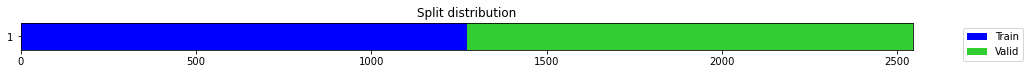

In [ ]:
inf_path = './data/1-Cycle'

v2xdata = V2XData(inf_path, hazard_thr=3)
X_inf, y_inf, splits, df = v2xdata.get_all_item()
v2xdata.get_data_info(X_inf, y_inf, splits)

check_data(X_inf, y_inf, splits=splits)

In [ ]:
tfms = [None, [Categorize()]]
batch_tfms = TSStandardize(by_sample=True)
dsets = TSDatasets(X, y, tfms=tfms)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
model = create_model(MLSTM_FCNPlus, dls = dls)
learner = Learner(dls, model, metrics=accuracy)
learner.load('model')

In [ ]:
# load model
# learner = load_learner_all(path='models', dls_fname='dls', model_fname='model', learner_fname='learner')
def matrix_result(learner, X, y):
    dls = learner.dls
    valid_dl = dls.valid

    # add Labelled test data
    test_ds = valid_dl.dataset.add_test(X, y) # test data
    test_dl = valid_dl.new(test_ds)
    test_probas, test_targets, test_preds = learner.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
    
    print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
    print(f'precision: {skm.precision_score(test_targets, test_preds):10.6f}')
    print(f'recall: {skm.recall_score(test_targets, test_preds):10.6f}')
    print(f'f1: {skm.f1_score(test_targets, test_preds):10.6f}')

    # compare on table
    test_preds_tensor = torch.tensor(test_preds)
    compare_table = pd.DataFrame([test_targets, test_preds_tensor])

accuracy:   0.892823
precision:   0.931818
recall:   0.436170
f1:   0.594203


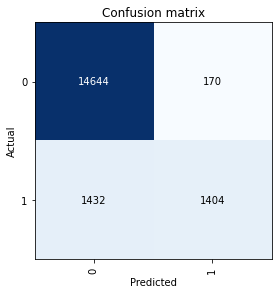

In [ ]:
# print((valid_targets == valid_preds).float().mean())
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

# end inference

In [ ]:
minirocket_classification(X, y, splits, epochs=50, model=MiniRocketPlus, lr = 1e-3, metrics=accuracy, lr_find=False)

IndexError: index 1045 is out of bounds for axis 0 with size 1045

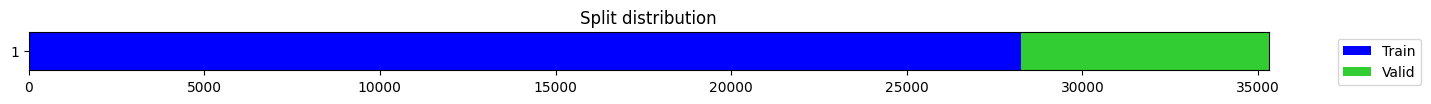

epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,0.565267,0.356054,0.213370,0.225500,00:00
1,0.401678,0.295153,0.181121,0.198120,00:00


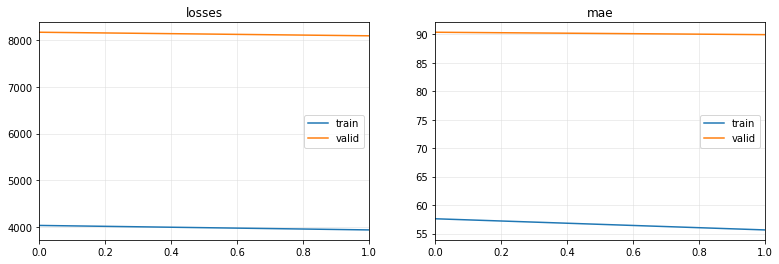

In [ ]:
multivariate_forecasting(X_all, y_all, splits, epochs=2, model=LSTM, lr = 1e-3, lr_find=False)

# TS Classification

In [ ]:
multivariate_classification(X_all, y_all, splits, epochs=300, model=MLSTM_FCNPlus, lr = 1e-3, metrics=accuracy, device='cpu')

# TS Classification

In [2]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToMat()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

NameError: name 'Categorize' is not defined

# load labled data

In [2]:
from modules.v2x import V2XData,V2XDataLabeled
from tsai.all import *
from tqdm import tqdm
from modules.RunTSAI import RunTSAI
from sklearn.utils import shuffle

conditions = ['A', 'D', 'F', 'N']
dates_range = ['220801', '220802', '220803', '220804', '220805', '220806', '220807', '220808', '220809', '220810', '220811', '220812', '220813', '220814', '220815', '220816', '220817', '220818', '220819', '220820', '220821', '220822', '220823', '220824', '220825', '220826', '220827', '220828', '220829', '220830', '220831']


In [ ]:
config = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = MLSTM_FCNPlus, # LSTM, MLSTM_Plus
    lr = 1e-3,
    n_epochs = 100,
)

data_path = f'data/labeled/{dates_range[0]}/C'

def mk_traindata(data_path):
    # X_sum, y_sum = empty numpy array
    X_sum = np.empty((0, 50, 1))
    y_sum = np.empty((0, 1))
    
    for cond in range(4): # 4 conditions
        v2xdata_ = V2XDataLabeled(data_path, condition = conditions[cond]) # load data scenarios
        for idx in range(len(v2xdata_)):
            X, y, _, df = v2xdata_[idx]
            X_sum = np.concatenate((X_sum, X), axis=0) if X_sum.size else X
            y_sum = np.concatenate((y_sum, y), axis=0) if y_sum.size else y
        splits = V2XDataLabeled.get_splits(None,X_sum, test_size = 0.2)
    
    print(X_sum.shape, y_sum.shape)
    print(splits[0][:10], splits[1][:10])
    
    return X_sum, y_sum, splits

X_sum = np.empty((0, 50, 1))
y_sum = np.empty((0, 1))

for idx in tqdm(range(20, len(dates_range))):
    X, y, _ = mk_traindata(f'data/labeled/{dates_range[idx]}/C')
    X_sum = np.concatenate((X_sum, X), axis=0) if X_sum.size else X
    y_sum = np.concatenate((y_sum, y), axis=0) if y_sum.size else y
splits = V2XDataLabeled.get_splits(None,X_sum, test_size = 0.2)


In [4]:
with open('data/X_sum_21-31.npy', 'wb') as f:
    np.save(f, X_sum)
with open('data/y_sum_21-31.npy', 'wb') as f:
    np.save(f, y_sum)

In [ ]:
X_sum = np.empty((0, 50, 1))
y_sum = np.empty((0, 1))

for idx in tqdm(range(10, 19)):
    X, y, _ = mk_traindata(f'data/labeled/{dates_range[idx]}/C')
    X_sum = np.concatenate((X_sum, X), axis=0) if X_sum.size else X
    y_sum = np.concatenate((y_sum, y), axis=0) if y_sum.size else y
splits = V2XDataLabeled.get_splits(None,X_sum, test_size = 0.2)

with open('data/X_sum_11-19.npy', 'wb') as f:
    np.save(f, X_sum)
with open('data/y_sum_11-19.npy', 'wb') as f:
    np.save(f, y_sum)

X      - shape: [300000 samples x 7 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (300000,)  type: ndarray  dtype:<U7  n_classes: 4 (75000 samples per class) ['False', 'Left', 'Reverse', 'Right']  isnan: False
splits - n_splits: 2 shape: [240000, 60000]  overlap: False


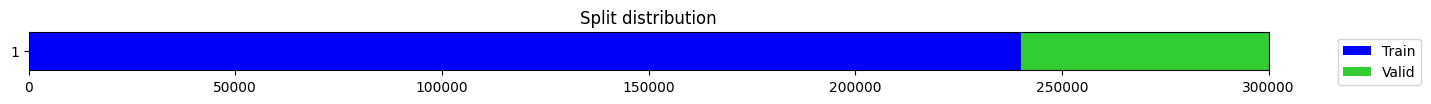

epoch,train_loss,valid_loss,accuracy,time
0,0.094337,1.112502,0.418617,00:30
1,0.071054,0.456251,0.764317,00:26
2,0.055382,0.099057,0.972567,00:26
3,0.053543,0.921216,0.668883,00:26
4,0.047964,0.085261,0.970900,00:27
5,0.040376,0.084157,0.974667,00:27
6,0.040563,1.970155,0.632533,00:27
7,0.035156,1.157657,0.701067,00:27
8,0.031970,0.440873,0.942000,00:27
9,0.032394,3.264254,0.203267,00:27


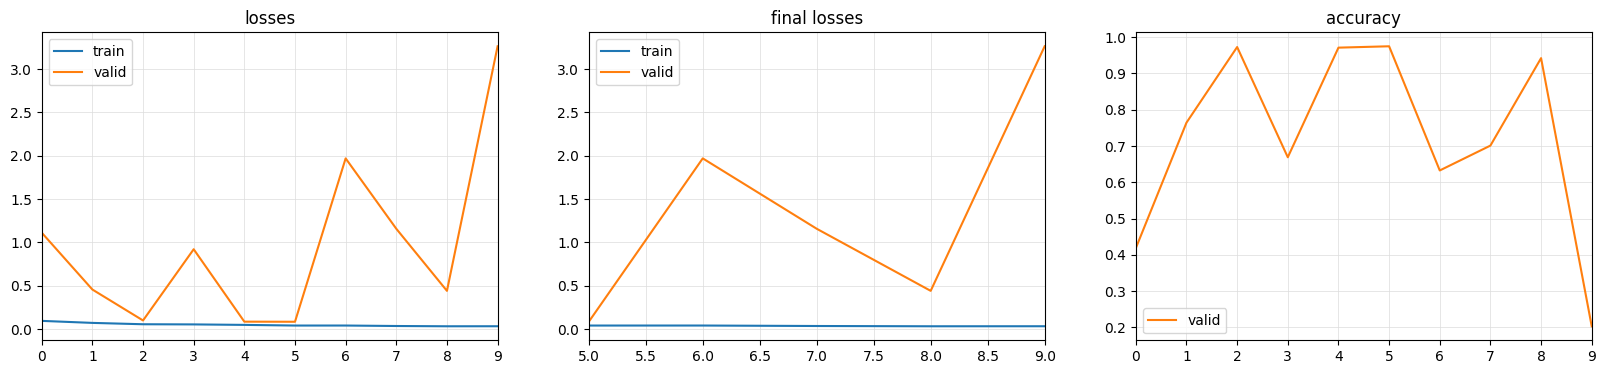

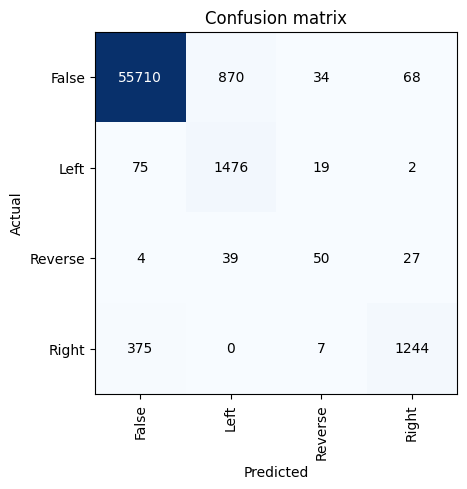

In [7]:
# load data
X_sum = np.load('data/X_sum_01-10.npy', allow_pickle=True)
y_sum = np.load('data/y_sum_01-10.npy', allow_pickle=True)
splits = V2XDataLabeled.get_splits(None,X_sum, test_size = 0.2)

config["n_epochs"] = 10

learner = RunTSAI.multivariate_classification(X_sum, y_sum[:, 0], splits, config=config, save = "MLSTM_FCNPlus_500") # train model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_confusion_matrix(normalize=True)

X      - shape: [300000 samples x 7 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (300000,)  type: ndarray  dtype:<U7  n_classes: 4 (75000 samples per class) ['False', 'Left', 'Reverse', 'Right']  isnan: False
splits - n_splits: 2 shape: [240000, 60000]  overlap: False


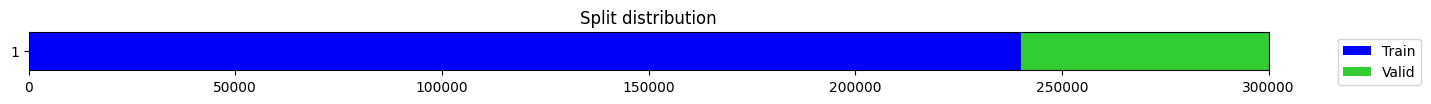

epoch,train_loss,valid_loss,accuracy,time
0,0.128523,0.610365,0.808117,00:14
1,0.082913,0.544978,0.823567,00:14
2,0.066583,0.714613,0.757350,00:14
3,0.058627,0.150719,0.963417,00:14
4,0.046197,0.610747,0.903717,00:14
5,0.046082,0.190745,0.965167,00:14
6,0.038911,5.677883,0.300517,00:14
7,0.035422,0.055860,0.981233,00:14
8,0.033569,5.427671,0.502833,00:15
9,0.035589,2.231857,0.737017,00:14


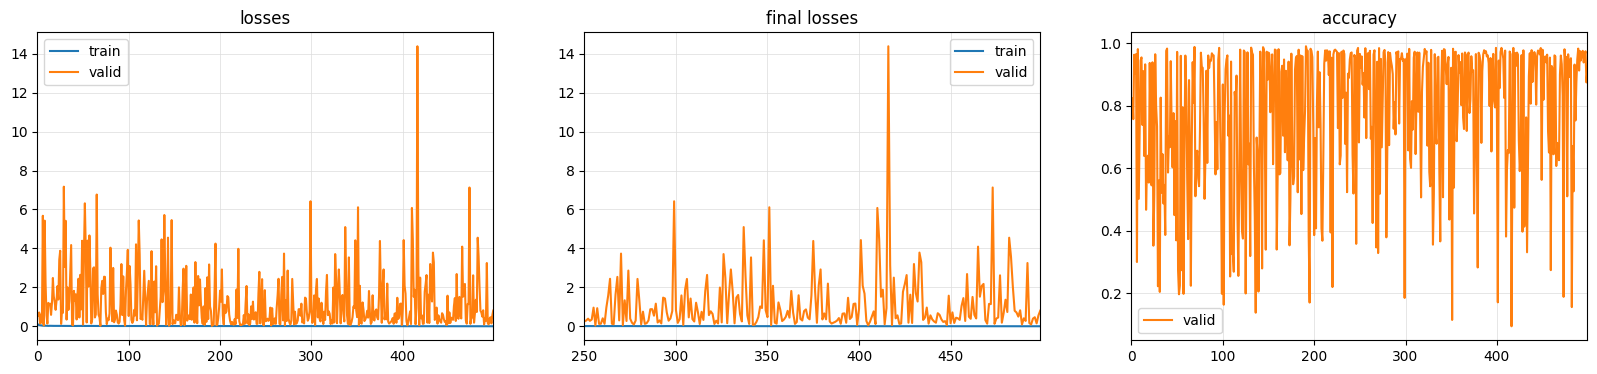

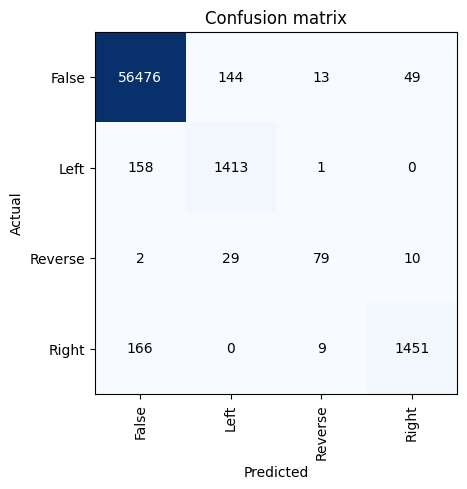

In [50]:
config["n_epochs"] = 500

learner = RunTSAI.multivariate_classification(X_sum, y_sum[:, 0], splits, config=config, save = "MLSTM_FCNPlus_500") # train model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

## .....

In [ ]:
# load test data


# add Labelled test data
test_ds = valid_dl.dataset.add_test(X, y) # test data
test_dl = valid_dl.new(test_ds)
test_probas, test_targets, test_preds = learner.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'precision: {skm.precision_score(test_targets, test_preds):10.6f}')
print(f'recall: {skm.recall_score(test_targets, test_preds):10.6f}')
print(f'f1: {skm.f1_score(test_targets, test_preds):10.6f}')


In [2]:
dataset_info = pd.DataFrame(columns=['시퀀스 명', '시퀀스 길이(초)', "Turn의 False 비율(%)", "Lane의 False 비율(%)", "Speed의 False 비율(%)", "Hazard의 False 비율(%)"])
def make_dataset_info(v2xdata, dataset_info, date):
    for idx in range(0, len(v2xdata)):
        try:
            X, y, splits, df = v2xdata[idx]
            print(f"클립 {os.path.basename(v2xdata.dataset_scenario[idx])}의 길이: {len(y)}초, ", end='\t')
            print(f"'Turn'의 False 비율: {len( y[:, 0][y[:, 0] == 'False']) / len(y[:, 0]) * 100:0.2f}%, ", end='\t')
            print(f"'Lane'의 False 비율: {len( y[:, 1][y[:, 1] == 'False']) / len(y[:, 1]) * 100:0.2f}%, ", end='\t')
            print(f"'Speed'의 False 비율: {len( y[:, 2][y[:, 2] == 'False']) / len(y[:, 2]) * 100:0.2f}%, ", end='\t')
            print(f"'Hazard'의 False 비율: {len( y[:, 3][y[:, 3] == 'False']) / len(y[:, 3]) * 100:0.2f}%")
            dataset_info.loc[idx] = [os.path.basename(v2xdata.dataset_scenario[idx]), len(y), len( y[:, 0][y[:, 0] == 'False']) / len(y[:, 0]) * 100, len( y[:, 1][y[:, 1] == 'False']) / len(y[:, 1]) * 100, len( y[:, 2][y[:, 2] == 'False']) / len(y[:, 2]) * 100, len( y[:, 3][y[:, 3] == 'False']) / len(y[:, 3]) * 100]
        except:
            continue
        
    dataset_info.to_csv(f'./data/raw/{date}_{v2xdata.condition}_dataset_info.csv', index=False)

In [ ]:
data_path = f'data/labeled/{dates_range[0]}/C'

for d in dates_range:
    data_path_repeate = f'data/labeled/{d}/C'
    for condition in conditions:
        v2xdata_ = V2XDataLabeled(data_path_repeate, condition = condition)
        make_dataset_info(v2xdata_, dataset_info, d)

# test

In [5]:
# combine all the data
v2x_data_x = np.load("data/X_sum_all.npy", allow_pickle=True)
v2x_data_y = np.load("data/y_sum_all.npy", allow_pickle=True)
y_turn, y_lane, y_speed, y_hazard = v2x_data_y[:, 0], v2x_data_y[:, 1], v2x_data_y[:, 2], v2x_data_y[:, 3]
X = v2x_data_x

In [6]:
from collections import Counter

ct_turn, ct_lane, ct_speed, ct_hazard = Counter(y_turn), Counter(y_lane), Counter(y_speed), Counter(y_hazard)

print(ct_turn, "\n", ct_lane, "\n", ct_speed, "\n", ct_hazard)

Counter({'False': 848269, 'Right': 25795, 'Left': 24247, 'Reverse': 1689}) 
 Counter({'False': 900000}) 
 Counter({'False': 899281, 'Hbrk': 527, 'Acc': 192}) 
 Counter({'False': 896901, 'True': 3099})


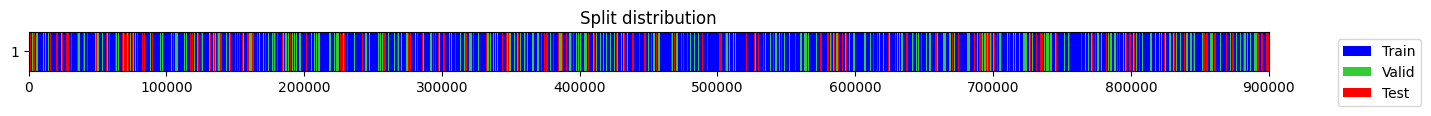

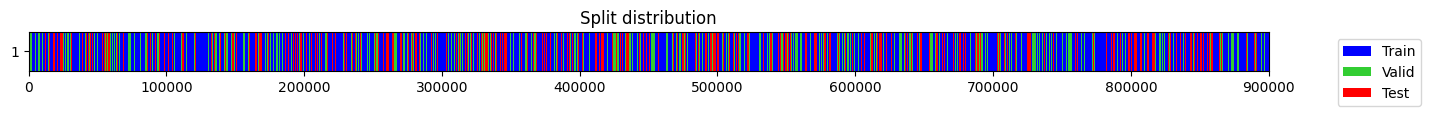

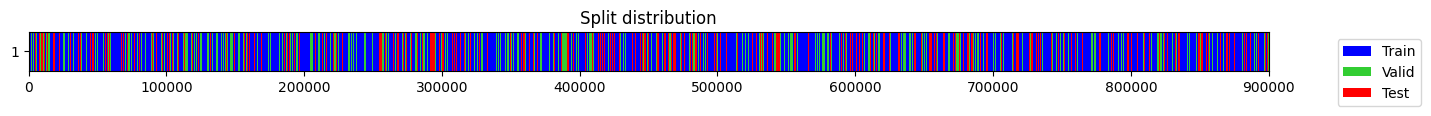

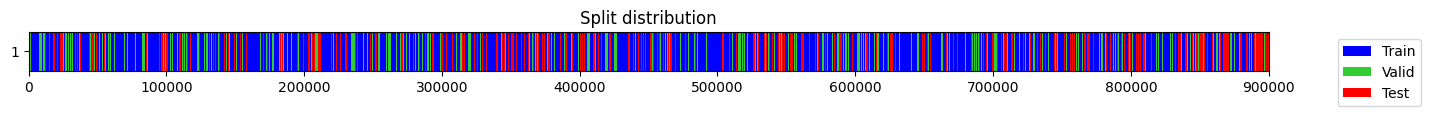

(((#540000) [466603,425813,302191,464215,523136,654173,795353,317379,156738,637261...],
  (#180000) [505096,115391,566475,234976,33151,604009,836808,376362,495974,327064...],
  (#180000) [4307,48331,791993,742586,785092,722920,535713,104547,581455,524989...]),
 ((#540000) [337367,274505,394237,466561,193516,578840,598618,762842,89904,408459...],
  (#180000) [804657,293374,627212,73178,516481,300368,383778,240999,414386,801494...],
  (#180000) [650304,808171,886607,795365,153243,118185,422738,168794,821447,353726...]),
 ((#540000) [209198,570993,859557,462082,127473,474505,886810,306493,805728,461613...],
  (#180000) [702873,196241,55046,793834,97563,862409,252391,606151,520844,853588...],
  (#180000) [206112,18514,871474,630340,452320,752006,316790,843626,446206,134187...]),
 ((#540000) [343006,175638,807994,648603,750129,102752,818953,206125,138606,161586...],
  (#180000) [774635,718675,433475,301430,21531,210320,61303,96779,167246,9635...],
  (#180000) [90899,341849,713402,133234,779

In [8]:
splits_turn = get_splits(v2x_data_y[:, 0], valid_size=0.2, test_size=0.2, random_state=42)
splits_lane = get_splits(v2x_data_y[:, 1], valid_size=0.2, test_size=0.2, random_state=42)
splits_speed = get_splits(v2x_data_y[:, 2], valid_size=0.2, test_size=0.2, random_state=42)
splits_hazard = get_splits(v2x_data_y[:, 3], valid_size=0.2, test_size=0.2, random_state=42)
splits_turn, splits_lane, splits_speed, splits_hazard

In [9]:
config = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = LSTM, # LSTM, MLSTM_Plus
    lr = 1e-3,
    n_epochs = 200,
)

X      - shape: [900000 samples x 7 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (900000,)  type: ndarray  dtype:<U7  n_classes: 4 (225000 samples per class) ['False', 'Left', 'Reverse', 'Right']  isnan: False
splits - n_splits: 3 shape: [540000, 180000, 180000]  overlap: False


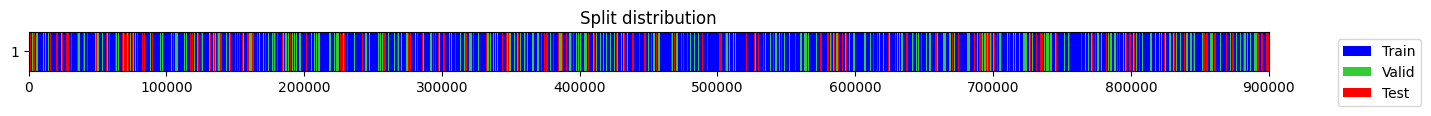

epoch,train_loss,valid_loss,accuracy,time
0,0.061772,0.573022,0.934556,00:33
1,0.045316,3.806031,0.268089,00:33
2,0.037276,3.894543,0.286494,00:31
3,0.032781,1.160694,0.781678,00:32
4,0.032898,1.207359,0.685978,00:31
5,0.028791,0.797566,0.714900,00:31
6,0.028323,5.454145,0.238194,00:32
7,0.028633,2.817920,0.398028,00:32
8,0.026857,1.306893,0.680433,00:32
9,0.024737,0.554085,0.777606,00:32


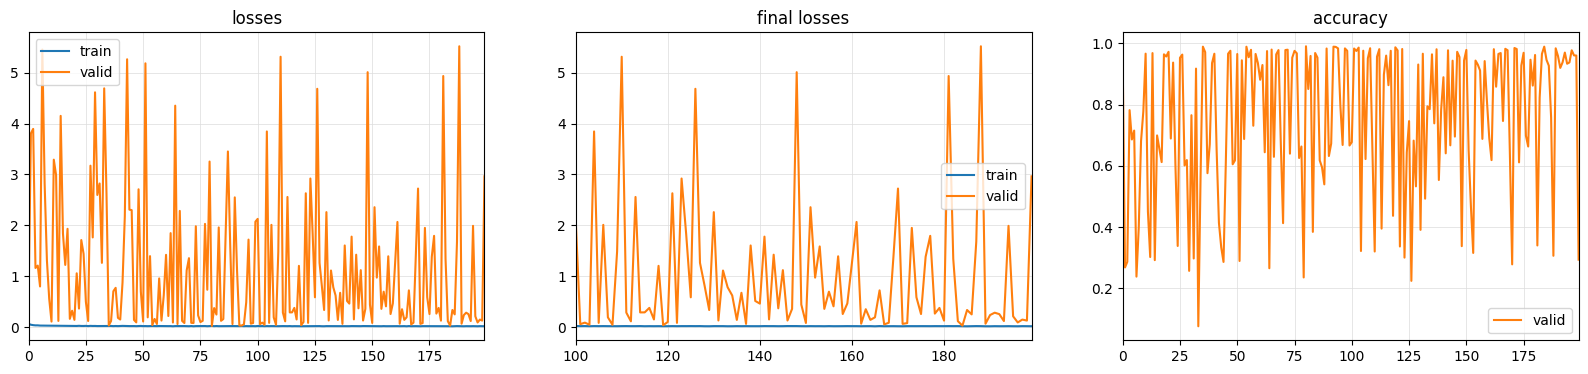

AttributeError: module 'datetime' has no attribute 'now'

In [12]:
learner_turn = RunTSAI.multivariate_classification(X, y_turn, splits_turn, config)
curr_time = datetime.now().strftime("%Y%m%d_%H%M")
learner_turn.save_all(path=f"models/turn_{curr_time}", dls_fname='dls_turn', model_fname='model_turn_MLSTM_FCNPlus', learner_fname='learner_turn')

In [ ]:
learner_lane = RunTSAI.multivariate_classification(X, y_lane, splits_lane, config)
curr_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")
learner_lane.save_all(path=f"models/lane_{curr_time}", dls_fname='dls_lane', model_fname='model_lane_MLSTM_FCNPlus', learner_fname='learner_lane')

X      - shape: [900000 samples x 7 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (900000,)  type: ndarray  dtype:<U7  n_classes: 3 (300000 samples per class) ['Acc', 'False', 'Hbrk']  isnan: False
splits - n_splits: 3 shape: [540000, 180000, 180000]  overlap: False


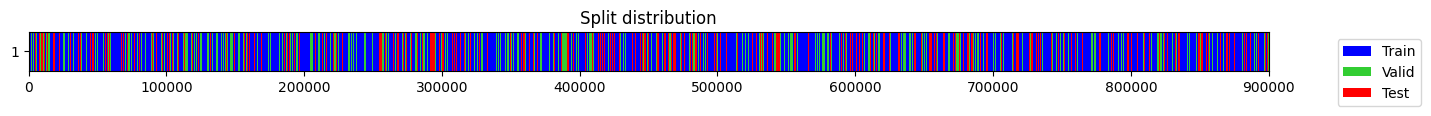

epoch,train_loss,valid_loss,accuracy,time
0,0.004711,0.005086,0.999200,00:45
1,0.003025,0.003040,0.999383,00:36
2,0.002273,0.005207,0.999239,00:55
3,0.003707,0.004870,0.998989,00:38
4,0.002862,0.005737,0.999239,00:37
5,0.001381,0.002706,0.999439,00:38
6,0.002868,0.006912,0.998428,00:33
7,0.001734,0.002822,0.999450,00:40
8,0.002811,0.081608,0.983789,00:36
9,0.002483,6.174669,0.014083,00:37


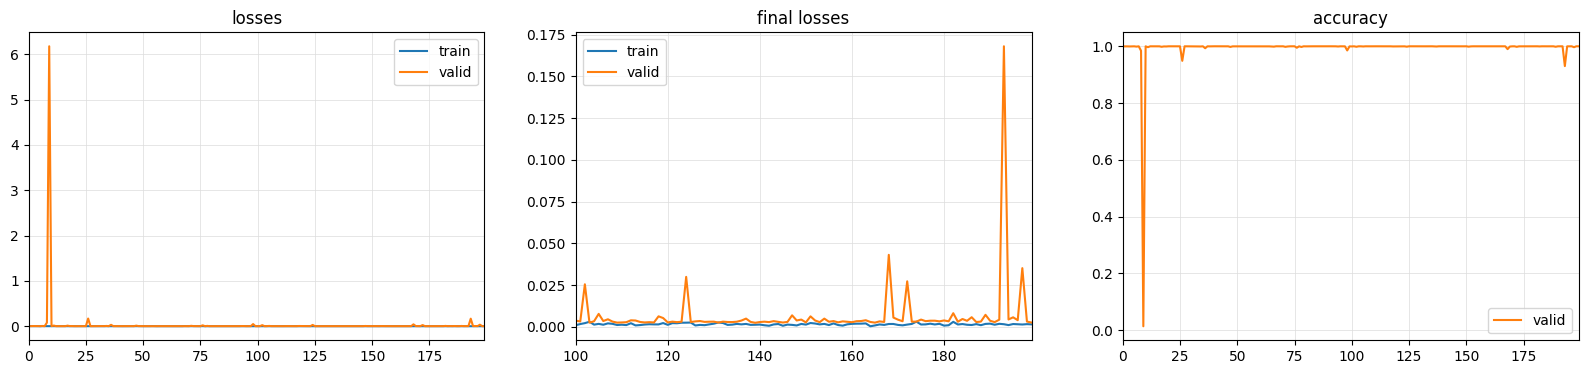

In [14]:
learner_speed = RunTSAI.multivariate_classification(X, y_speed, splits_speed, config)
curr_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")
learner_speed.save_all(path=f"models/speed_{curr_time}", dls_fname='dls_speed', model_fname='model_speed_MLSTM_FCNPlus', learner_fname='learner_speed')

X      - shape: [900000 samples x 7 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (900000,)  type: ndarray  dtype:<U7  n_classes: 2 (450000 samples per class) ['False', 'True']  isnan: False
splits - n_splits: 3 shape: [540000, 180000, 180000]  overlap: False


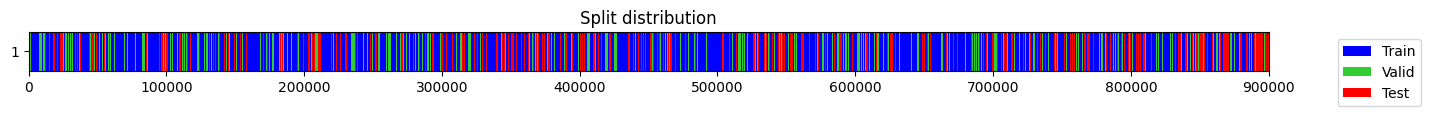

epoch,train_loss,valid_loss,accuracy,time
0,0.023432,0.022926,0.996556,00:51
1,0.022662,0.023037,0.996556,00:43
2,0.020163,0.022914,0.996556,00:44
3,0.023572,0.022917,0.996556,00:45
4,0.023225,0.022992,0.996556,00:48
5,0.022706,0.022944,0.996556,00:47
6,0.026631,0.023670,0.996556,00:46
7,0.024786,0.023434,0.996556,00:44
8,0.022508,0.022908,0.996556,00:45
9,0.026972,0.022919,0.996556,00:48


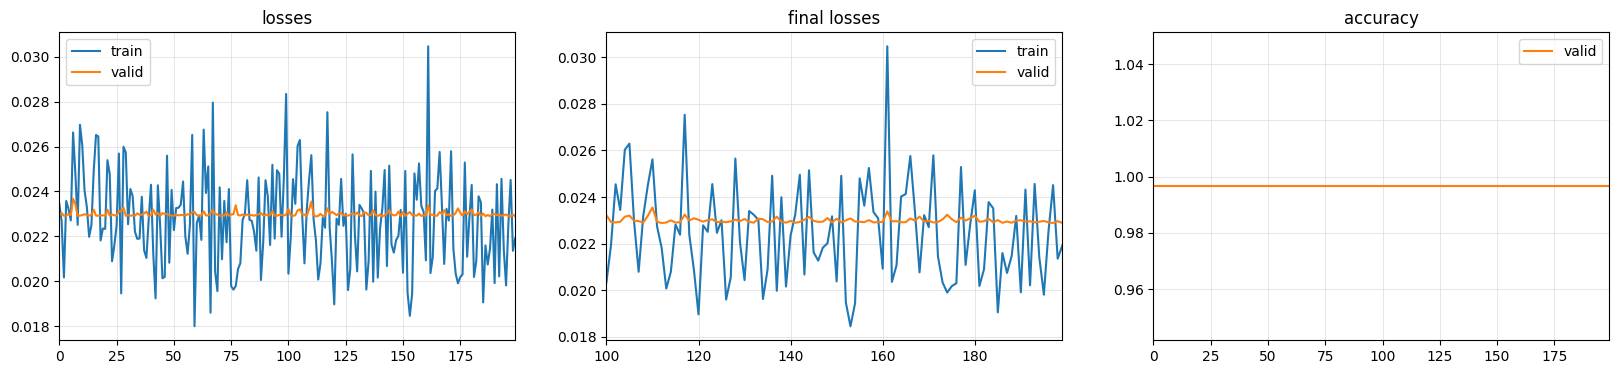

In [16]:
config["architecture"] = MLSTM_FCNPlus
learner_hazard = RunTSAI.multivariate_classification(X, y_hazard, splits_hazard, config)
curr_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")
learner_hazard.save_all(path=f"models/hazard_{curr_time}", dls_fname='dls_hazard', model_fname='model_hazard_MLSTM_FCNPlus', learner_fname='learner_hazard')

# load model

In [ ]:
learner1 = load_learner_all(path="models", dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learner1.dls
valid_dl = dls.valid

learner1.get_preds(dl= valid_dl, with_decoded=True)

In [ ]:
test_ds = valid_dl.dataset.add_test(v2x_data_x[1000:2000], v2x_data_y[1000:2000, 0])
test_dl = valid_dl.new(test_ds)

test_probas, test_targets, test_preds = learner1.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

In [26]:
import sklearn.metrics as skm

print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'precision: {skm.precision_score(test_targets, test_preds, average="weighted"):10.6f}')
print(f'recall: {skm.recall_score(test_targets, test_preds, average="weighted"):10.6f}')
print(f'f1: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.934000
precision:   0.872356
recall:   0.934000
f1:   0.902126
